Model: "Elman"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ SimpleRNN (SimpleRNN)           │ (None, 90, 2)          │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189 (756.00 B)

 Trainable params: 189 (756.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1075 - mae: 0.2572
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0349 - mae: 0.1494 
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - mae: 0.1166 
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - mae: 0.1138
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - mae: 0.0885
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - mae: 0.0878 
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - mae: 0.0940 
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - mae: 0.0813 
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - mae: 0.0904 
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - mae: 0.0942 
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - mae: 0.0807 
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - mae: 0.0840 
Epoch 13/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0

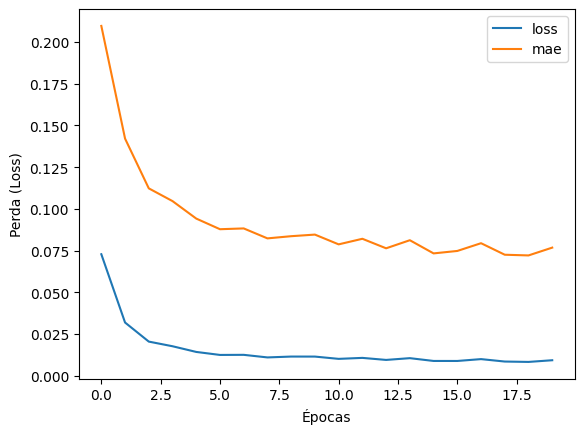

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


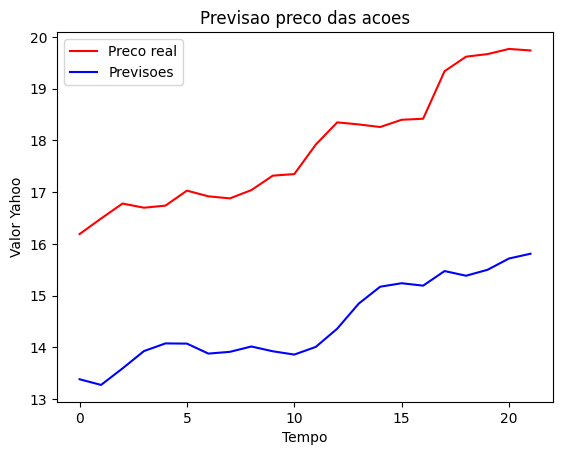

In [2]:
# -*- coding: utf-8 -*- 

# Carregamento das bibliotecas 
from __future__ import print_function 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential, Model 
from keras.layers import Input, SimpleRNN, Dense, Flatten 
from keras.optimizers import RMSprop 

# Carregamento da base  
## Base das ações da Petrobras entre os anos 2013 e 2017. 

df = pd.read_csv("./acoesPETR4.csv") 

# Eliminação de dados faltantes
# Verifica se existem valores faltantes 
teste = df.isnull().values.any() 

# Se existir valores faltantes, elimina da base 
if teste: 
    df = df.dropna() 

# Construção dos dados para uma modelo temporal
# base de treinamento : valor da bolsa no momento da abertura 
base_treino = df.iloc[:, 1:2].values 
# normalizando os dados 
normalizador = MinMaxScaler(feature_range=(0,1)) 
base_treino_normalizada = normalizador.fit_transform(base_treino) 

# Definição do Time Step
time_step = 90

# Geração das séries temporais 
## Com o time-step igual a 90: 

# estruturando a base de dados para a Rede de Elman 
# criar noventa datas anteriores do preço da ação da data que será prevista 
previsores = [] 
preco_real = [] 
for i in range(time_step, base_treino.shape[0]): 
    previsores.append(base_treino_normalizada[i - time_step:i, 0]) 
    preco_real.append(base_treino_normalizada[i,0]) 
# converte para o formato numpy 
previsores, preco_real = np.array(previsores), np.array(preco_real) 
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1)) 

# Geração do modelo
# formato dos dados  
previsores.shape 
modelo = Sequential(name="Elman") 
modelo.add(Input(shape=(time_step, previsores.shape[-1]), name="Input")) 
modelo.add(SimpleRNN(units=2, return_sequences=True, unroll=True, name="SimpleRNN")) 
modelo.add(Flatten()) 
modelo.add(Dense(units=1, activation='linear', name='Output')) 
modelo.compile(loss='mean_squared_error', optimizer=RMSprop(), metrics=['mae']) 
modelo.summary() 

# Treinamento 
epochs = 20
batch_size = 64
hist = modelo.fit( 
    previsores, 
    preco_real, 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1 
) 

# Avaliação da precisão do modelo 
## Gráficos do processo de aprendizagem 

pd.DataFrame(hist.history).plot() 
plt.xlabel('Épocas') 
plt.ylabel('Perda (Loss)') 
plt.show()

### Teste 
# previsão dos preços 
base_teste = pd.read_csv('./acoesPETR4teste.csv') 
preco_real_teste = base_teste['Open'].values 
base_completa = pd.concat((df['Open'], base_teste['Open']), axis=0) 
entradas = base_completa[len(base_completa) - len(base_teste) - time_step:].values 
entradas = entradas.reshape(-1,1) 
entradas = normalizador.transform(entradas) 
X_teste = [] 

# 112 = len(base_teste) + 90 
for i in range(time_step, 112): 
    X_teste.append(entradas[i-time_step:i, 0]) 
X_teste = np.array(X_teste) 
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1)) 

## Predição
previsoes = modelo.predict(X_teste) 
previsoes = normalizador.inverse_transform(previsoes) 

plt.plot(preco_real_teste, color = 'red', label = 'Preco real') 
plt.plot(previsoes, color = 'blue', label = 'Previsoes') 
plt.title('Previsao preco das acoes') 
plt.xlabel('Tempo') 
plt.ylabel('Valor Yahoo') 
plt.legend() 
plt.show() 
